OBJECTIVE:
-->Perform Logistic Regression using 2 fold cross validation, on Amazon Fine food reviews to predict the polarity of the review as either 'Positive' or 'Negative'. The LR is to be performed via L1 and L2 regularization implemetation on following text vectorization models such as:
1)Bag of Words
2)TF-IDF
3)Avg Word2Vec
4)TF-IDF Word2Vec

-->Come up with the optimal Lambda using the 2-fold cross validation technique and use the same to predict the future TEST data and determine the various metrics such as accuracy,F1 ,precision,confusion matrix and recall scores for the same.

-->Perform the cross validation for Lambda using both GridSearch and Random Search.

-->Get the most important features for both classes and try to interpret the model.

-->Try to analyse the sparsity and Performance trade-off by increasing the values of Lambda for L1 regularizer.

In [1]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn import cross_validation
import warnings
import sqlite3
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
# =============================================================================================

c:\users\rahul\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Loading the final dataset of AFF after Data preprocessing and removing duplicates done previously in TSNE

con = sqlite3.connect('C:\\Users\\rahul\\Desktop\\AI COURSE\\Amazon Fine food\\amazon-fine-food-reviews (1)\\final.sqlite')

In [3]:
data = pd.read_sql_query("""SELECT * FROM REVIEWS """,con)
print(data.shape)

#check no of Positive and negative reviews present
data['Score'].value_counts()

#Performing Time based slicing on the data
sorted_data = data.sort_values('Time')

#since facing memory issue just taking 100k data points
sample_data = sorted_data.head(n=1000)

print(sample_data.shape)


(364171, 12)
(1000, 12)


In [4]:
label = sample_data['Score']

# split the data set into train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(sample_data, label, test_size=0.3, random_state=0)

type(sample_data)

pandas.core.frame.DataFrame

BOW Model:

In [5]:
#Bag of words using Scikit learn
count_vect = CountVectorizer(dtype = 'float64')
vocab = count_vect.fit(X_train['CleanedText'].values)
type(vocab)

#Using the vocab obtained in train to vectorize both train and test data
X_train = vocab.transform(X_train['CleanedText'].values)
X_test = vocab.transform(X_test['CleanedText'].values)
epsilon = np.random.normal(loc=0.0, scale=0.001)
X_train_per = X_train
X_test_per = X_test
X_train_per.data = X_train_per.data + epsilon
X_test_per.data = X_test_per.data + epsilon

In [6]:
#Standardise the Data as part of data pre-processing for LR

from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_train)
X_train = Scaler.transform(X_train)
X_test = Scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(700, 5439)
(300, 5439)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegressionCV
from wordcloud import WordCloud

#function to find the optimal lambda in LR for 5 fold cross validation
def find_optimal_lambda(x,y,k,search,pen):
    
    grid_list = [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]
    uni_dist = uniform(10**-4,10**4)
        
    if((search == 'Grid') and (pen == 'l1') ):
        tuned_parameters = [{'C': grid_list}]
        model = GridSearchCV(LogisticRegression(penalty = 'l1',class_weight= 'balanced'), tuned_parameters, scoring = 'accuracy',n_jobs=-1, cv=k)
    
    elif((search == 'Grid') and (pen == 'l2') ):
        tuned_parameters = [{'C': grid_list}]
        model = GridSearchCV(LogisticRegression(penalty = 'l2',class_weight= 'balanced'), tuned_parameters, scoring = 'accuracy',n_jobs=-1, cv=k)
    
    elif((search == 'Random') and (pen == 'l1')):
        
        tuned_parameters = {'C': uni_dist}
        model = RandomizedSearchCV(LogisticRegression(penalty = 'l1',class_weight= 'balanced'), tuned_parameters, scoring = 'accuracy',n_jobs=-1, cv=k)
    
    elif((search == 'Random') and (pen == 'l2')):
        tuned_parameters = {'C': uni_dist}
        model = RandomizedSearchCV(LogisticRegression(penalty = 'l2',class_weight= 'balanced'), tuned_parameters, scoring = 'accuracy',n_jobs=-1, cv=k)
    
    model.fit(x,y)
    

      # Get Test Scores Mean and std for each grid search
    scores_mean = model.cv_results_['mean_test_score']
    uni_list = model.cv_results_['params']
    
    rand_list = [] 
    
    for i in uni_list:
        rand_list.append(i['C'])
    
    rand_list.sort()
    if(search == 'Grid'):
        scores_mean = np.array(scores_mean).reshape(len(grid_list))
        
        errors_mean = 1 - scores_mean

        plt.plot(grid_list,errors_mean)

        for xy in zip(grid_list, np.round(errors_mean,3)):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

        plt.xlabel('c - value')
        plt.ylabel('Misclassification Error')
        plt.show()
    
    elif(search == 'Random'):
        scores_mean = np.array(scores_mean).reshape(len(rand_list))
        errors_mean = 1 - scores_mean

        plt.plot(rand_list,errors_mean)

        for xy in zip(rand_list, np.round(errors_mean,3)):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

        plt.xlabel('c - value')
        plt.ylabel('Misclassification Error')
        plt.show()
    
    
    return model
        
    # ============================== LR with lambda = optimal_lambda ===============================================

#function to predict the label of test data and return the same as list 
def pred_test_data(x_tr,y_tr,x_tst,y_tst,model):
    
    LR = model

    # predict the response
    pred = LR.predict(x_tst)
    
    # evaluate accuracy
    acc = accuracy_score(y_tst, pred) * 100
    print('\nThe accuracy of the LR classifier for is %f%%' % ( acc))
    
    return pred

#Function to create Confusion matrix creation and plotting the same
def confusion_heatmap(x,y):
    cnf_mat = confusion_matrix(x,y)
    #labels = ['Negative' , 'Positive']
    print("Confusion matrix is : " ,cnf_mat )
    ax = sns.heatmap(cnf_mat,cbar_kws={'label': 'colorbar title'},cmap='YlGnBu',linewidths=2, linecolor='yellow')
    # X - Y axis labels
    ax.set_ylabel('Predicted Polarity')
    ax.set_xlabel('Actual Polarity')    
    ax.set_xticklabels(['Negative' , 'Positive'])
    ax.set_yticklabels(['Negative' , 'Positive'])

def metric_score(x,y):
    print("The precision score for our model is: ", precision_score(x,y)) 
    print("The f1 score for our model is: ", f1_score(x,y))
    print("The recall score for our model is: ", recall_score(x,y))
    print("The accuracy of our model is: ", accuracy_score(x,y))

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(relative_scaling = 1.0 ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    

#Function to increase lambda and check for sparsity and performance 
def sparsity_perf_tradeoff(x_tr,y_tr,x_tst,y_tst,pen):
    # creating a list of alpha for NB
    c_list = [10**4,10**3,10**2,10**1,10**0,10**-1,10**-2,10**-3,10**-4]
    sparsity_list = []
    for c_value in c_list:
        clf = LogisticRegression(penalty = pen,C=c_value)
        clf.fit(x_tr,y_tr)
        y_pred = clf.predict(x_tst)
        f1 =  f1_score(y_tst,y_pred)
        sparsity_list.append(np.count_nonzero(clf.coef_))
        print("For Lambda value of {}, The Sparsity is {} and f1 score is {} ".format(1/c_value,np.count_nonzero(clf.coef_),f1))
    
    plt.plot(c_list, sparsity_list)

    for xy in zip(c_list, sparsity_list):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('C - value')
    plt.ylabel('Sparsity value')
    plt.show()
        


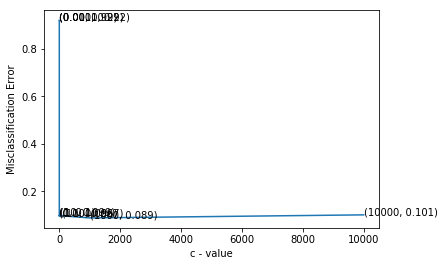


The accuracy of the LR classifier for is 91.000000%
Confusion matrix is :  [[  4  17]
 [ 10 269]]
The precision score for our model is:  0.9405594405594405
The f1 score for our model is:  0.9522123893805309
The recall score for our model is:  0.96415770609319
The accuracy of our model is:  0.91


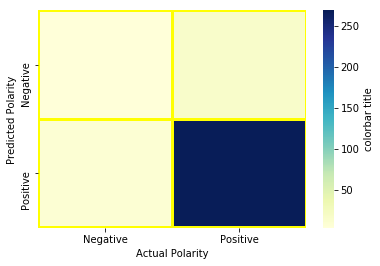

In [8]:
# find the optimal plane using grid search and L1 regualarisation 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)


opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Grid','l1')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)

coef_org = opt_plane.best_estimator_.coef_



Interpretaion: 
1) We are getting a FN and FP value of 949 and 2117 while TN and TP value of 2716 and 24218.
2) This shows we are doing really well in Postive classification.
3) However we have a high False positive value as well which shows higher misclassification of negative class. 

PERTUBATION TECHNIQUE:

Apply the model on perturbed data and check for multicollinearity.

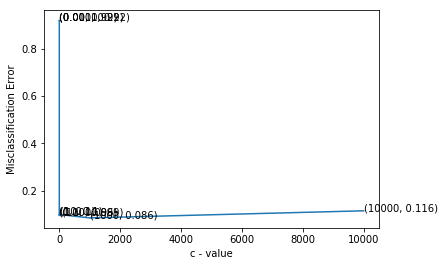


The accuracy of the LR classifier for is 92.000000%
Confusion matrix is :  [[  5  16]
 [  8 271]]
The precision score for our model is:  0.9442508710801394
The f1 score for our model is:  0.9575971731448764
The recall score for our model is:  0.9713261648745519
The accuracy of our model is:  0.92
[[0. 0. 0. ... 0. 0. 0.]]


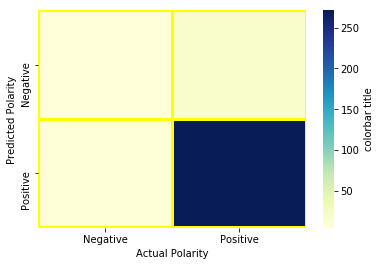

In [9]:
#perform the model on perturbed data to find multicollinearity
# find the optimal plane using grid search and L1 regualarisation 

epsilon = np.random.normal(loc=0.0, scale=0.001)
X_train_per = X_train
X_test_per = X_test
X_train_per.data = X_train_per.data + epsilon
X_test_per.data = X_test_per.data + epsilon

opt_plane = find_optimal_lambda(X_train_per,y_en_train,2,'Grid','l1')
y_pred = pred_test_data(X_train_per,y_en_train,X_test_per,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)


metric_score(y_en_test,y_pred)

coef_per = opt_plane.best_estimator_.coef_
print(coef_per)



Interpretaion: 
1) We are getting a FN and FP value of 758 and 2286 while TN and TP value of 2907 and 24049.
2) This shows we are doing really well in Postive classification.
3) However we have a high False positive value as well which shows higher misclassification of negative class.

MULTICOLLINEARITY CHECK:

check if more features changes by more than 30%, then do not use plane weights as feature importance.

In [10]:
print(coef_org.shape)
# diff = (abs((coef_org-coef_per)/coef_org)>.3).sum()
# print(diff)
# print("Only {0:.2f} % of features have weights change more than 30%".format((diff/len(coef_org[0,:])*100)))

# neg_class_wt_sorted = np.argsort(coef_org)
# pos_class_wt_sorted = np.argsort(-coef_org)
# #If less than 15 % proceed with feature importance
# # print("The most important features for negative class are :", np.take(count_vect.get_feature_names(), neg_class_wt_sorted[:,:10]))

# # print("The most important features for positive class are :", np.take(count_vect.get_feature_names(), pos_class_wt_sorted[:,:10]))
# neg_class_wt_sorted = np.argsort(coef_org)
# pos_class_wt_sorted = np.argsort(-coef_org)

# neg_text = np.take(count_vect.get_feature_names(), neg_class_wt_sorted[:,:10])
# pos_text = np.take(count_vect.get_feature_names(), pos_class_wt_sorted[:,:10])

# nega_text = " ".join(words for words in neg_text[0])
# posi_text = " ".join(words for words in pos_text[0])

# print("The wordcloud for top 10 negative features are:")
# generate_wordcloud(nega_text)

# print("The wordcloud for top 10 positive features are:")
# generate_wordcloud(posi_text)

(1, 5439)


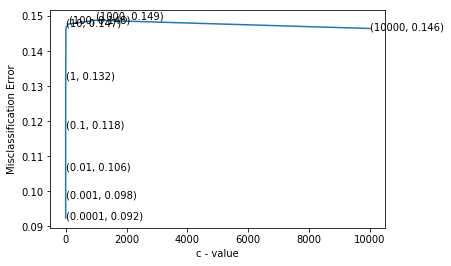


The accuracy of the LR classifier for is 90.406667%
Confusion matrix is :  [[ 2833   832]
 [ 2046 24289]]
The precision score for our model is:  0.9668802993511405
The f1 score for our model is:  0.9440687189054726
The recall score for our model is:  0.922308714638314
The accuracy of our model is:  0.9040666666666667


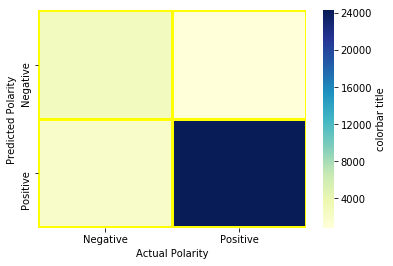

In [11]:
# find the optimal plane using grid search and L2 regualarisation 

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Grid','l2')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)


confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 832 and 2046 while TN and TP value of 2833 and 24289.
2) This shows we are doing really well in Postive classification.
3) However we have a high False positive value as well which shows higher misclassification of negative class.

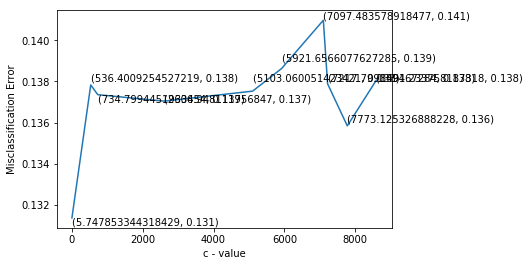


The accuracy of the LR classifier for is 87.596667%
Confusion matrix is :  [[ 2332  1333]
 [ 2388 23947]]
The precision score for our model is:  0.9472705696202531
The f1 score for our model is:  0.9279085537150054
The recall score for our model is:  0.9093221947977976
The accuracy of our model is:  0.8759666666666667


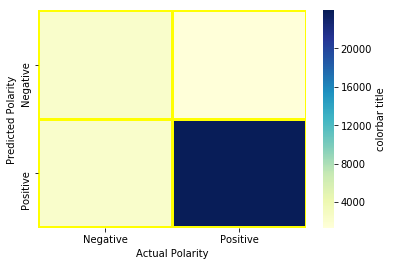

In [12]:
# find the optimal plane using Random search and L1 regualarisation 

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Random','l1')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 1333 and 2388 while TN and TP value of 2332 and 23947.
2) This shows we are doing really well in Postive classification.
3) However we have a very high False positive value as well which shows higher misclassification of negative class.

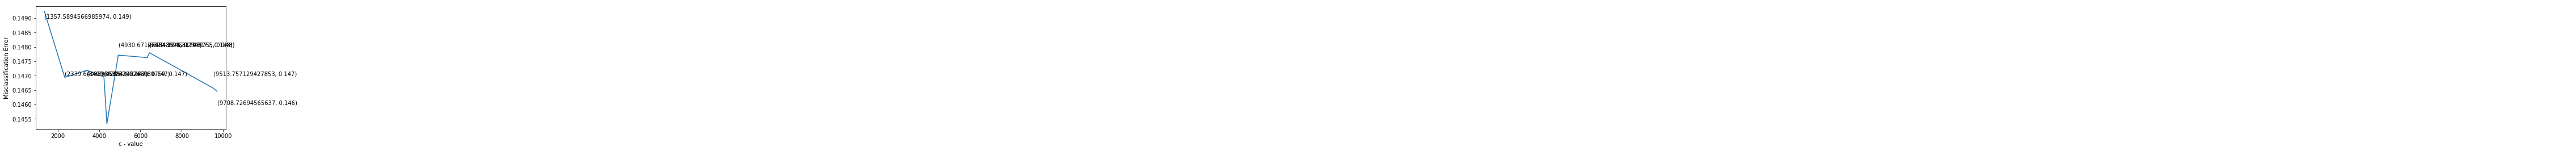


The accuracy of the LR classifier for is 85.803333%
Confusion matrix is :  [[ 2324  1341]
 [ 2918 23417]]
The precision score for our model is:  0.9458356894741093
The f1 score for our model is:  0.9166422014757404
The recall score for our model is:  0.8891968862730207
The accuracy of our model is:  0.8580333333333333


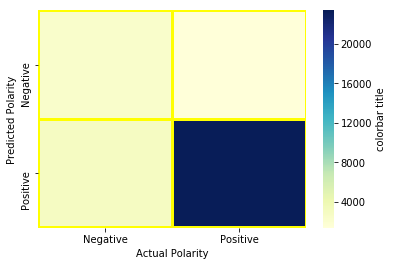

In [13]:
# find the optimal plane using Random search and L2 regualarisation 

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Random','l2')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)
   
metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 1341 and 2918 while TN and TP value of 2324 and 23417.
2) This shows we are doing really well in Postive class classification.
3) However we have a high False positive value as well which shows higher misclassification of negative class.

For Lambda value of 0.0001, The Sparsity is 22991 and f1 score is 0.9303608365892899 
For Lambda value of 0.001, The Sparsity is 19579 and f1 score is 0.9322215422276623 
For Lambda value of 0.01, The Sparsity is 17100 and f1 score is 0.932876659905859 
For Lambda value of 0.1, The Sparsity is 14445 and f1 score is 0.9355862227149356 
For Lambda value of 1.0, The Sparsity is 12213 and f1 score is 0.9432956319737995 
For Lambda value of 10.0, The Sparsity is 9622 and f1 score is 0.9551698795861836 
For Lambda value of 100.0, The Sparsity is 3194 and f1 score is 0.9573917224544143 
For Lambda value of 1000.0, The Sparsity is 61 and f1 score is 0.9403236199613374 
For Lambda value of 10000.0, The Sparsity is 0 and f1 score is 0.9349427531729831 


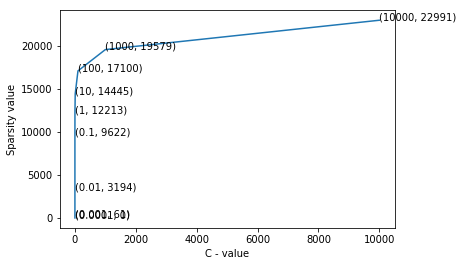

In [14]:
#Vary the values of lambda and try to check sparsity performance tradeoff

sparsity_perf_tradeoff(X_train,y_en_train,X_test,y_en_test,'l1')

| Search Type | Regularisation | C-Value | Accuracy |F1-Score|
| --- | --- | --- |--- |
| Grid | L1 | 0.1 | 89.78 | 94.04 |
| Grid | L2 | 0.0001 | 90.40 | 94.41 |
| Random | L1 | 5.745 | 87.60 | 92.79 |
| Random | L2 | 4200 | 85.80 | 91.86 |

Conclusion:

1)The LR was performed on AFF using BOW model via L1 regularization and L2 regularization using both Gridsearch and Randomsearch.
2)For Gridsearch we get an accuracy of 89.78% for L1 reg and 90.41% for L2 reg.
3)For Randomsearch we get an accuracy of 87.60% for L1 reg and 85.80% for L2 reg.
4)From above 2 points we can see that L1 reg performs better than L2 reg as L2 reg introduces sparsity to less important features which might lead to performance loss.
5)We analyse performance vs Sparsity by increasing the value of lambda. As Lambda increases, the sparsity increases but it also leads to tip in performance.

TF-IDF MODEL:

In [15]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(sample_data, label, test_size=0.3, random_state=0)
#Converting text into vector using tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab = tf_idf_vect.fit(X_train['CleanedText'].values)
X_train = vocab.transform(X_train['CleanedText'].values)
X_test = vocab.transform(X_test['CleanedText'].values)

type(X_train)

scipy.sparse.csr.csr_matrix

In [16]:
#Standardise the Data as part of data pre-processing for LR

from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_train)
X_train = Scaler.transform(X_train)
X_test = Scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(70000, 928799)
(30000, 928799)


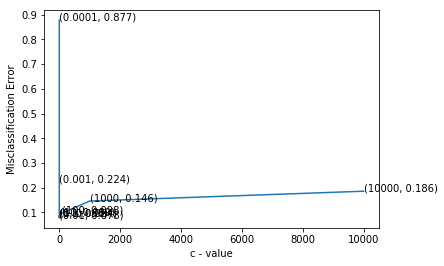


The accuracy of the LR classifier for is 93.053333%
Confusion matrix is :  [[ 2500  1165]
 [  919 25416]]
The precision score for our model is:  0.9561717015913622
The f1 score for our model is:  0.9606168266686823
The recall score for our model is:  0.9651034744636415
The accuracy of our model is:  0.9305333333333333
[[ 0.          0.         -0.00089747 ...  0.          0.
   0.        ]]


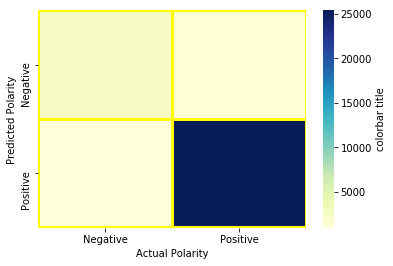

In [17]:
# find the optimal plane using grid search and L1 regualarisation 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)


opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Grid','l1')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)


metric_score(y_en_test,y_pred)

coef_org = opt_plane.best_estimator_.coef_
print(coef_org)



Interpretaion: 
1) We are getting a FN and FP value of 1165 and 919 while TN and TP value of 2500 and 25416.
2) This shows we are doing phenomenally well in Postive classification.
3) However we have a high False negative value as well.

The wordcloud for top 10 negative features are:


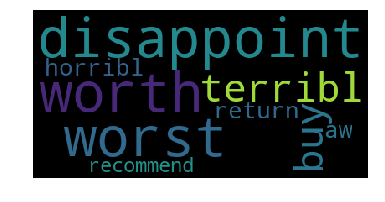

The wordcloud for top 10 positive features are:


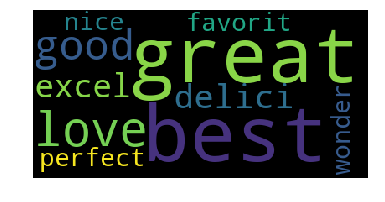

In [18]:

neg_class_wt_sorted = np.argsort(coef_org)
pos_class_wt_sorted = np.argsort(-coef_org)
#If less than 15 % proceed with feature importance

neg_text = np.take(tf_idf_vect.get_feature_names(), neg_class_wt_sorted[:,:10])
pos_text = np.take(tf_idf_vect.get_feature_names(), pos_class_wt_sorted[:,:10])

nega_text = " ".join(words for words in neg_text[0])
posi_text = " ".join(words for words in pos_text[0])

print("The wordcloud for top 10 negative features are:")
generate_wordcloud(nega_text)

print("The wordcloud for top 10 positive features are:")
generate_wordcloud(posi_text)

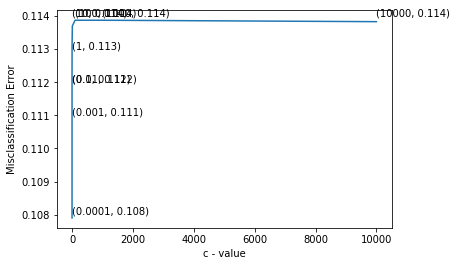


The accuracy of the LR classifier for is 90.966667%
Confusion matrix is :  [[ 1117  2548]
 [  162 26173]]
The precision score for our model is:  0.9112844260297344
The f1 score for our model is:  0.9507773902935193
The recall score for our model is:  0.9938484906018606
The accuracy of our model is:  0.9096666666666666


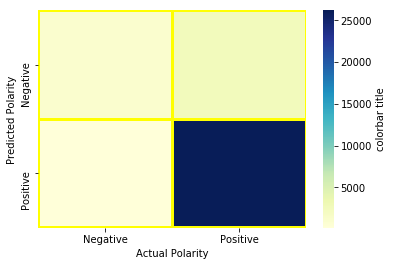

In [19]:
# find the optimal plane using grid search and L2 regualarisation 

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Grid','l2')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)


confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 2548 and 162 while TN and TP value of 1117 and 26173.
2) This shows we are doing really well in Postive classification.
3) However we have a high False negative value as well which shows higher misclassification of positive class.

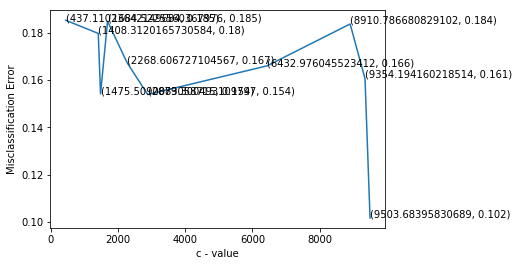


The accuracy of the LR classifier for is 88.486667%
Confusion matrix is :  [[ 1587  2078]
 [ 1376 24959]]
The precision score for our model is:  0.9231423604689869
The f1 score for our model is:  0.9352844187963726
The recall score for our model is:  0.9477501423960509
The accuracy of our model is:  0.8848666666666667


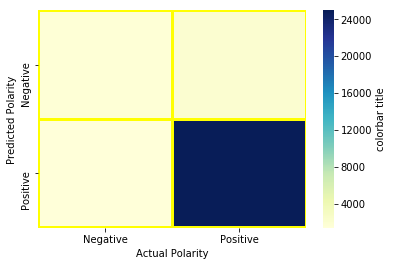

In [20]:
# find the optimal plane using Random search and L1 regualarisation 

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Random','l1')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 2078 and 1376 while TN and TP value of 1587 and 24959.
2) This shows we are doing really well in Postive classification.
3) However we have a high False Negative value as well which shows higher misclassification of positive class.

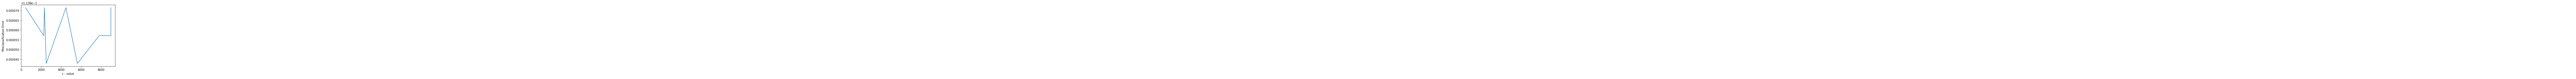


The accuracy of the LR classifier for is 90.410000%
Confusion matrix is :  [[  888  2777]
 [  100 26235]]
The precision score for our model is:  0.9042809871777195
The f1 score for our model is:  0.9480188628109925
The recall score for our model is:  0.9962027719764572
The accuracy of our model is:  0.9041


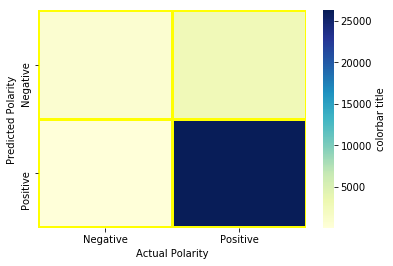

In [21]:
# find the optimal plane using Random search and L2 regualarisation 

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Random','l2')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 2777 and 100 while TN and TP value of 888 and 26235.
2) This shows we are doing really well in Postive classification.
3) However we have a very high False positive value as well which shows higher misclassification of negative class.

| Search Type | Regularisation | C-Value | Accuracy |F1-Score|
| --- | --- | --- |--- |
| Grid | L1 | 0.1 | 93.05 | 96.06 |
| Grid | L2 | 0.0001 | 90.96 | 95.07 |
| Random | L1 | 9503 | 88.48 | 93.52 |
| Random | L2 | 2250 | 90.41 | 94.80 |

Conclusion:

1)The LR was performed on AFF using TF-IDF model via L1 regularization and L2 regularization using both Gridsearch and Randomsearch.
2)For Gridsearch we get an accuracy of 93.05% for L1 reg and 90.96% for L2 reg.
3)For Randomsearch we get an accuracy of 88.48% for L1 reg and 90.41% for L2 reg.
4)From above 2 points we can see that L1 reg performs better than L2 reg in GridSearch for Tf-IDF but vice-versa in RandomSearch.

WORD2VEC MODEL:

In [22]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(sample_data, label, test_size=0.3, random_state=0)
#fetching the list of sentences from cleanedtext column of our train data for word2vec model
i=0
list_of_sent=[]
for sent in X_train['CleanedText'].values:
    list_of_sent.append(sent.split())

In [23]:
from gensim.models import Word2Vec

# min_count = 5 considers only words that occured atleast 3 times
w2v_model=Word2Vec(list_of_sent,min_count=3,size=50, workers=4)

In [24]:
w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
sent_train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_train_vectors.append(sent_vec)
print(len(sent_train_vectors))
print(len(sent_train_vectors[0]))
 

70000
50


In [25]:
i=0
list_of_sent=[]
for sent in X_test['CleanedText'].values:
    list_of_sent.append(sent.split())

In [26]:
sent_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_test_vectors.append(sent_vec)
print(len(sent_test_vectors))
print(len(sent_test_vectors[0]))
 

30000
50


In [27]:
X_train = sent_train_vectors
X_test = sent_test_vectors

Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_train)
X_train = Scaler.transform(X_train)
X_test = Scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(70000, 50)
(30000, 50)


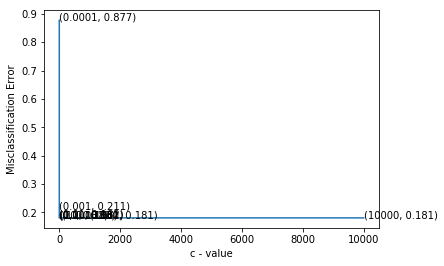


The accuracy of the LR classifier for is 81.806667%
Confusion matrix is :  [[ 3062   603]
 [ 4855 21480]]
The precision score for our model is:  0.9726939274555088
The f1 score for our model is:  0.8872733281011194
The recall score for our model is:  0.8156445794569964
The accuracy of our model is:  0.8180666666666667


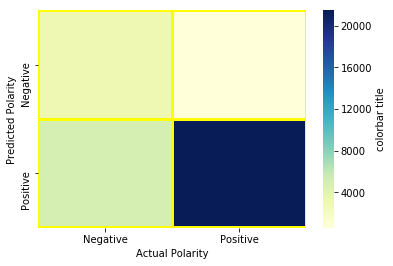

In [28]:
# find the optimal plane using grid search and L1 regualarisation

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Grid','l1')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)

coef_org = opt_plane.best_estimator_.coef_



Interpretaion: 
1) We are getting a FN and FP value of 603 and 4855 while TN and TP value of 3062 and 21480.
2) This shows we are doing really well in Postive classification.
3) However we have a high False positive value as well which shows higher misclassification of negative class.

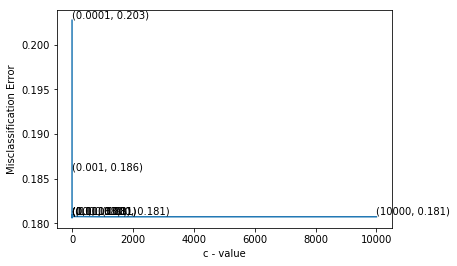


The accuracy of the LR classifier for is 81.823333%
Confusion matrix is :  [[ 3059   606]
 [ 4847 21488]]
The precision score for our model is:  0.9725717389336471
The f1 score for our model is:  0.8874021763819199
The recall score for our model is:  0.8159483576988799
The accuracy of our model is:  0.8182333333333334


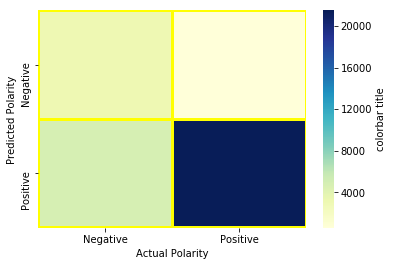

In [29]:
# find the optimal plane using grid search and L2 regualarisation 
 
opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Grid','l2')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)


confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 606 and 4847 while TN and TP value of 3059 and 21488.
2) This shows we are doing really well in Postive classification.
3) However we have a high False positive value as well which shows higher misclassification of negative class.

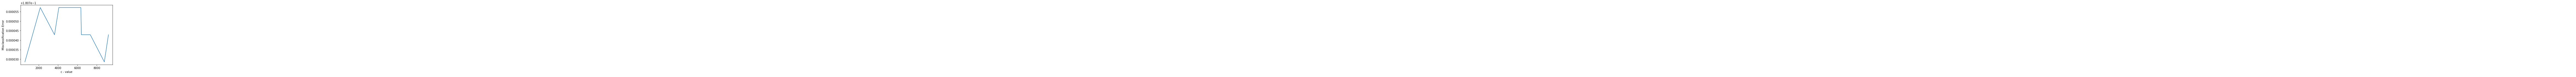


The accuracy of the LR classifier for is 81.820000%
Confusion matrix is :  [[ 3063   602]
 [ 4852 21483]]
The precision score for our model is:  0.9727416798732171
The f1 score for our model is:  0.8873605947955391
The recall score for our model is:  0.8157584962977027
The accuracy of our model is:  0.8182


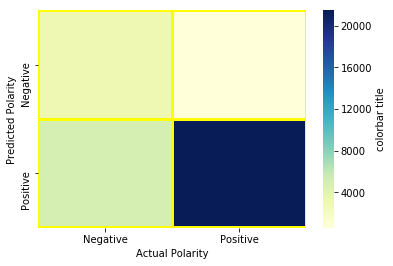

In [30]:
# find the optimal plane using Random search and L1 regualarisation 

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Random','l1')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 602 and 4852 while TN and TP value of 3063 and 21483.
2) This shows we are doing really well in Postive classification.
3) However we have a high False positive value as well which shows higher misclassification of negative class.

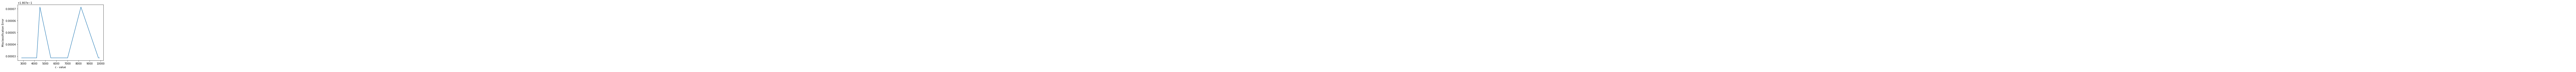


The accuracy of the LR classifier for is 81.823333%
Confusion matrix is :  [[ 3064   601]
 [ 4852 21483]]
The precision score for our model is:  0.9727857272233291
The f1 score for our model is:  0.8873789214977592
The recall score for our model is:  0.8157584962977027
The accuracy of our model is:  0.8182333333333334


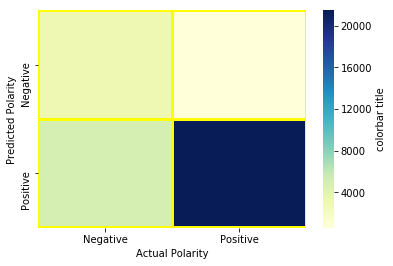

In [31]:
# find the optimal plane using Random search and L2 regualarisation 

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Random','l2')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 601 and 4852 while TN and TP value of 3064 and 21483.
2) This shows we are doing really well in Postive classification.
3) However we have a very high False positive value as well which shows higher misclassification of negative class.

| Search Type | Regularisation | C-Value | Accuracy |F1-Score|
| --- | --- | --- |--- |
| Grid | L1 | 0.1 | 81.81 | 88.93 |
| Grid | L2 | 0.1 | 81.82 | 88.74 |
| Random | L1 | 3600 | 81.82 | 88.73 |
| Random | L2 | 3000 | 81.82 | 88.74 |

Conclusion:

1)The LR was performed on AFF using Word2Vec model via L1 regularization and L2 regularization using both Gridsearch and Randomsearch.
2)For Gridsearch we get an accuracy of 81.81% for L1 reg and 81.82% for L2 reg.
3)For Randomsearch we get an accuracy of 81.82% for L1 reg and 81.82% for L2 reg.
4)From above 2 points we can see that L1 reg and L2 reg in both search methods for Word2vec  are almost identical.


TF-IDF weighted WORD2VEC:

In [32]:
# TF-IDF weighted Word2Vec
X_train, X_test, y_train, y_test = cross_validation.train_test_split(sample_data, label, test_size=0.3, random_state=0)
#fetching the list of sentences from cleanedtext column of our train data for word2vec model
i=0
list_of_sent=[]
for sent in X_train['CleanedText'].values:
    list_of_sent.append(sent.split())
    
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
vocab = tf_idf_vect.fit(X_train['CleanedText'].values)
X_train_tfidf = vocab.transform(X_train['CleanedText'].values)
X_test_tfidf = vocab.transform(X_test['CleanedText'].values)

tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_feat, list(tf_idf_vect.idf_)))
type(X_train)

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
#             tf_idf = X_train_tfidf[row, tfidf_feat.index(word)]
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1

X_train = tfidf_train_vectors

In [33]:
# TF-IDF weighted Word2Vec
#fetching the list of sentences from cleanedtext column of our train data for word2vec model
i=0
list_of_sent=[]
for sent in X_test['CleanedText'].values:
    list_of_sent.append(sent.split())
    
type(X_train)

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
#             tf_idf = X_train_tfidf[row, tfidf_feat.index(word)]
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1

X_test = tfidf_test_vectors

In [34]:
Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_train)
X_train = Scaler.transform(X_train)
X_test = Scaler.transform(X_test)

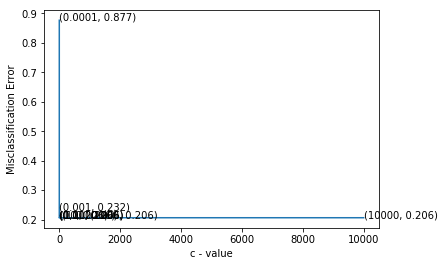


The accuracy of the LR classifier for is 79.710000%
Confusion matrix is :  [[ 2922   743]
 [ 5344 20991]]
The precision score for our model is:  0.9658139320879727
The f1 score for our model is:  0.873369531298758
The recall score for our model is:  0.7970761344218721
The accuracy of our model is:  0.7971


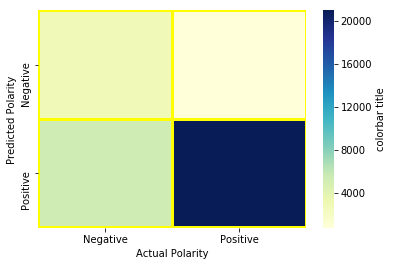

In [35]:
# find the optimal plane using grid search and L1 regualarisation

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Grid','l1')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)


metric_score(y_en_test,y_pred)

coef_org = opt_plane.best_estimator_.coef_



Interpretaion: 
1) We are getting a FN and FP value of 743 and 5344 while TN and TP value of 2922 and 20991.
2) This shows we are doing really well in Postive classification.
3) However we have a very high False positive value as well which shows higher misclassification of negative class.

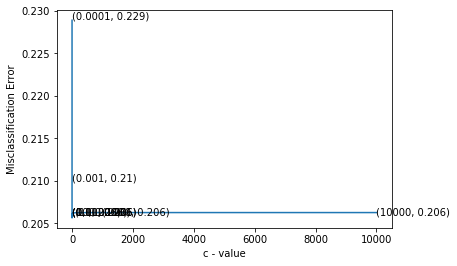


The accuracy of the LR classifier for is 79.796667%
Confusion matrix is :  [[ 2921   744]
 [ 5317 21018]]
The precision score for our model is:  0.9658119658119658
The f1 score for our model is:  0.8739838243549494
The recall score for our model is:  0.7981013859882286
The accuracy of our model is:  0.7979666666666667


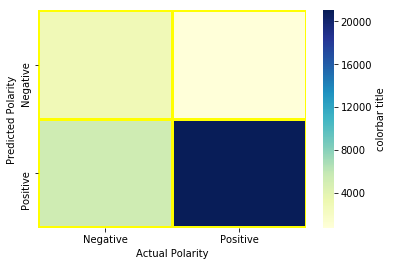

In [36]:
# find the optimal plane using grid search and L2 regualarisation 

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Grid','l2')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 744 and 5317 while TN and TP value of 2921 and 21018.
2) This shows we are doing really well in Postive classification.
3) However we have a very high False positive value as well which shows higher misclassification of negative class.

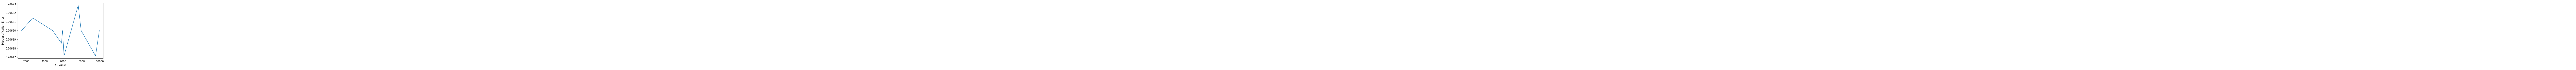


The accuracy of the LR classifier for is 79.570000%
Confusion matrix is :  [[ 2914   751]
 [ 5378 20957]]
The precision score for our model is:  0.9654044591855537
The f1 score for our model is:  0.8724267843390296
The recall score for our model is:  0.7957850768938675
The accuracy of our model is:  0.7957


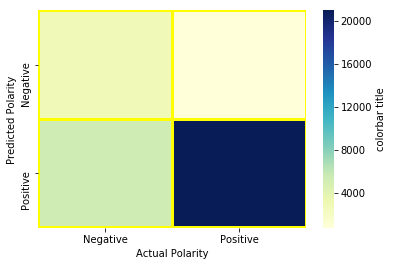

In [37]:
# find the optimal plane using Random search and L1 regualarisation 

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Random','l1')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 751 and 5378 while TN and TP value of 2914 and 20957.
2) This shows we are doing really well in Postive classification.
3) However we have a very high False positive value as well which shows higher misclassification of negative class.

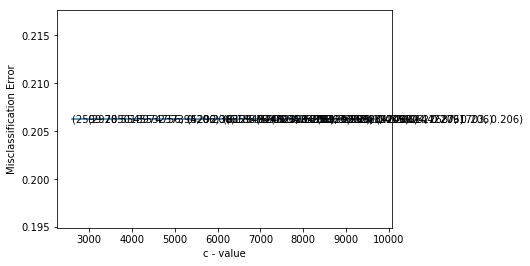


The accuracy of the LR classifier for is 79.573333%
Confusion matrix is :  [[ 2914   751]
 [ 5377 20958]]
The precision score for our model is:  0.9654060527891658
The f1 score for our model is:  0.872450253933894
The recall score for our model is:  0.795823049174103
The accuracy of our model is:  0.7957333333333333


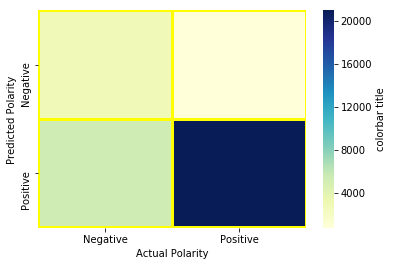

In [38]:
# find the optimal plane using Random search and L2 regualarisation 

opt_plane = find_optimal_lambda(X_train,y_en_train,2,'Random','l2')
y_pred = pred_test_data(X_train,y_en_train,X_test,y_en_test,opt_plane)
type(y_pred)

confusion_heatmap(y_en_test,y_pred)

metric_score(y_en_test,y_pred)


Interpretaion: 
1) We are getting a FN and FP value of 751 and 5377 while TN and TP value of 2914 and 20958.
2) This shows we are doing really well in Postive classification.
3) However we have a high False positive value as well which shows higher misclassification of negative class.

| Search Type | Regularisation | C-Value | Accuracy |F1-Score|
| --- | --- | --- |--- |
| Grid | L1 | 0.1 | 79.71 | 87.33 |
| Grid | L2 | 1 | 79.79 | 87.39 |
| Random | L1 | 2800 | 79.57 | 87.24 |
| Random | L2 | 3700 | 79.51 | 87.24 |

Conclusion:

1)The LR was performed on AFF using TF-IDF weighted Word2Vec model via L1 regularization and L2 regularization using both Gridsearch and Randomsearch.
2)For Gridsearch we get an accuracy of 79.71% for L1 reg and 79.79% for L2 reg.
3)For Randomsearch we get an accuracy of 79.57% for L1 reg and 79.51% for L2 reg.
4)From above 2 points we can see that L1 reg and L2 reg in both search methods for TF-IDF weighted Word2vec  are almost identical.